In [1]:
import os
import re
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# --- Data Loading & Cleaning ---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/datasets/final/medical_final_withId.csv')

In [5]:
"""
# extra cleaning i haven't tried it yet :/
def clean_text(text): ...
df['tokenized_text'] = df['description'].apply(clean_text)
"""

"\n# extra cleaning i haven't tried it yet :/\ndef clean_text(text): ...\ndf['tokenized_text'] = df['description'].apply(clean_text)\n"

## Filtering out small classes (<90 entries):
treating class embalance;


### TODO:

  [ ] explore better strategies


In [6]:
min_samples = 90
df = df.groupby('Specialty').filter(lambda x: len(x) >= min_samples)
print(f"Filtered dataset shape: {df.shape}")

Filtered dataset shape: (18587, 6)


# --- Embedding Generation (Basic 1 layer CLS) ---


### Remove any previously cached embeddings if they were generated on unfiltered data




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
token_texts = df['tokenized_text'].tolist()

## Load BioBERT with hidden states


In [8]:
model_name = 'EMBO/BioMegatron345mUncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/668M [00:00<?, ?B/s]

Some weights of MegatronBertModel were not initialized from the model checkpoint at EMBO/BioMegatron345mUncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MegatronBertModel(
  (embeddings): MegatronBertEmbeddings(
    (word_embeddings): Embedding(30592, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MegatronBertEncoder(
    (layer): ModuleList(
      (0-23): 24 x MegatronBertLayer(
        (attention): MegatronBertAttention(
          (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (self): MegatronBertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): MegatronBertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
  

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
token_texts = df['tokenized_text'].tolist()

## Extract the [CLS] token embeddings (first token of each sequence)

In [10]:
batch_size = 16
biobert_embeddings = []
num_batches = (len(df) + batch_size - 1) // batch_size
print(f"Generating BioBERT embeddings in {num_batches} batches...")

for i in range(0, len(df), batch_size):
    batch_texts = df['tokenized_text'][i:i+batch_size].tolist()
    encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    encoded_inputs = {k: v.to(device) for k, v in encoded_inputs.items()}
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    biobert_embeddings.append(cls_embeddings)
    print(f"Processed batch {i//batch_size + 1}/{num_batches}")

Generating BioBERT embeddings in 1162 batches...


model.safetensors:   0%|          | 0.00/668M [00:00<?, ?B/s]

Processed batch 1/1162
Processed batch 2/1162
Processed batch 3/1162
Processed batch 4/1162
Processed batch 5/1162
Processed batch 6/1162
Processed batch 7/1162
Processed batch 8/1162
Processed batch 9/1162
Processed batch 10/1162
Processed batch 11/1162
Processed batch 12/1162
Processed batch 13/1162
Processed batch 14/1162
Processed batch 15/1162
Processed batch 16/1162
Processed batch 17/1162
Processed batch 18/1162
Processed batch 19/1162
Processed batch 20/1162
Processed batch 21/1162
Processed batch 22/1162
Processed batch 23/1162
Processed batch 24/1162
Processed batch 25/1162
Processed batch 26/1162
Processed batch 27/1162
Processed batch 28/1162
Processed batch 29/1162
Processed batch 30/1162
Processed batch 31/1162
Processed batch 32/1162
Processed batch 33/1162
Processed batch 34/1162
Processed batch 35/1162
Processed batch 36/1162
Processed batch 37/1162
Processed batch 38/1162
Processed batch 39/1162
Processed batch 40/1162
Processed batch 41/1162
Processed batch 42/1162
P

## Saving the generated embeddings:

In [11]:
embedding_file = 'biobert_plain_embeddings.npy'
biobert_embeddings = np.vstack(biobert_embeddings)
np.save(embedding_file, biobert_embeddings)
print("BioBERT embeddings generated and saved.")
print(f"BioBERT embeddings shape: {biobert_embeddings.shape}")


BioBERT embeddings generated and saved.
BioBERT embeddings shape: (18587, 1024)


# Train/Validation/Test split

#### encoding labels (y's)

In [12]:
label_encoder = LabelEncoder()
df['specialty_encoded'] = label_encoder.fit_transform(df['Specialty'])
print("Label encoding sample:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


print(f"Number of samples in df: {len(df)}")


Label encoding sample: {'Cardiology': 0, 'Dentistry': 1, 'Dermatology': 2, 'ENT and Pulmonology': 3, 'Endocrinology': 4, 'Family Medicine': 5, 'Gastroenterology': 6, 'General Medicine': 7, 'Internal Medicine': 8, 'Neurology': 9, 'Obstetrics and Gynecology': 10, 'Ophthalmology': 11, 'Orthopedics and Traumatology': 12, 'Pediatrics': 13, 'Physiotherapy and Rehabilitation': 14, 'Psychology/Psychiatry': 15, 'Surgery': 16, 'Urology': 17}
Number of samples in df: 18587


In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    biobert_embeddings, df['specialty_encoded'], test_size=0.2, random_state=42, stratify=df['specialty_encoded']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 11151 samples
Validation set: 3718 samples
Test set: 3718 samples


# The classifier

## COnstruction

In [14]:
input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)

model_tf = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model_tf.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,930 (2.65 MB)

 Trainable params: 693,138 (2.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Training

In [15]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_medical_classifier.keras', monitor='val_accuracy', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model_tf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list
)

Epoch 1/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5333 - loss: 1.7231 - val_accuracy: 0.6649 - val_loss: 1.0738 - learning_rate: 0.0010
Epoch 2/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6591 - loss: 1.1220 - val_accuracy: 0.6947 - val_loss: 0.9638 - learning_rate: 0.0010
Epoch 3/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6955 - loss: 0.9867 - val_accuracy: 0.7195 - val_loss: 0.9153 - learning_rate: 0.0010
Epoch 4/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7113 - loss: 0.9128 - val_accuracy: 0.7109 - val_loss: 0.9041 - learning_rate: 0.0010
Epoch 5/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7315 - loss: 0.8610 - val_accuracy: 0.7370 - val_loss: 0.8620 - learning_rate: 0.0010
Epoch 6/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7405 - loss: 0.8176 - val_accuracy: 0.7308 - val_loss: 0.8531 - learning_rate: 0.0010
Epoch 7/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7451 - loss: 0.7863 

# --- Evaluation ---


Methode(s): we're calculating the accuracy / using a confusion matrix

In [16]:
test_loss, test_acc = model_tf.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

Test accuracy: 0.7512, loss: 0.7997


In [17]:
y_pred = np.argmax(model_tf.predict(X_test), axis=1)
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                                  precision    recall  f1-score   support

                      Cardiology       0.83      0.43      0.57        90
                       Dentistry       0.84      0.88      0.86       136
                     Dermatology       0.76      0.76      0.76       254
             ENT and Pulmonology       0.52      0.31      0.39        75
                   Endocrinology       0.53      0.41      0.46        49
                 Family Medicine       0.91      0.78      0.84       356
                Gastroenterology       0.60      0.21      0.31        43
                General Medicine       0.75      0.67      0.71       455
               Internal Medicine       0.30      0.50      0.38       318
                       Neurology       0.74      0.89      0.81       247
       Obstetrics and Gynecology       0.93      0.93      0.93       926
                   Ophthalmology       0.93      0.82      0.88       

### *Confusion matrix fuss*

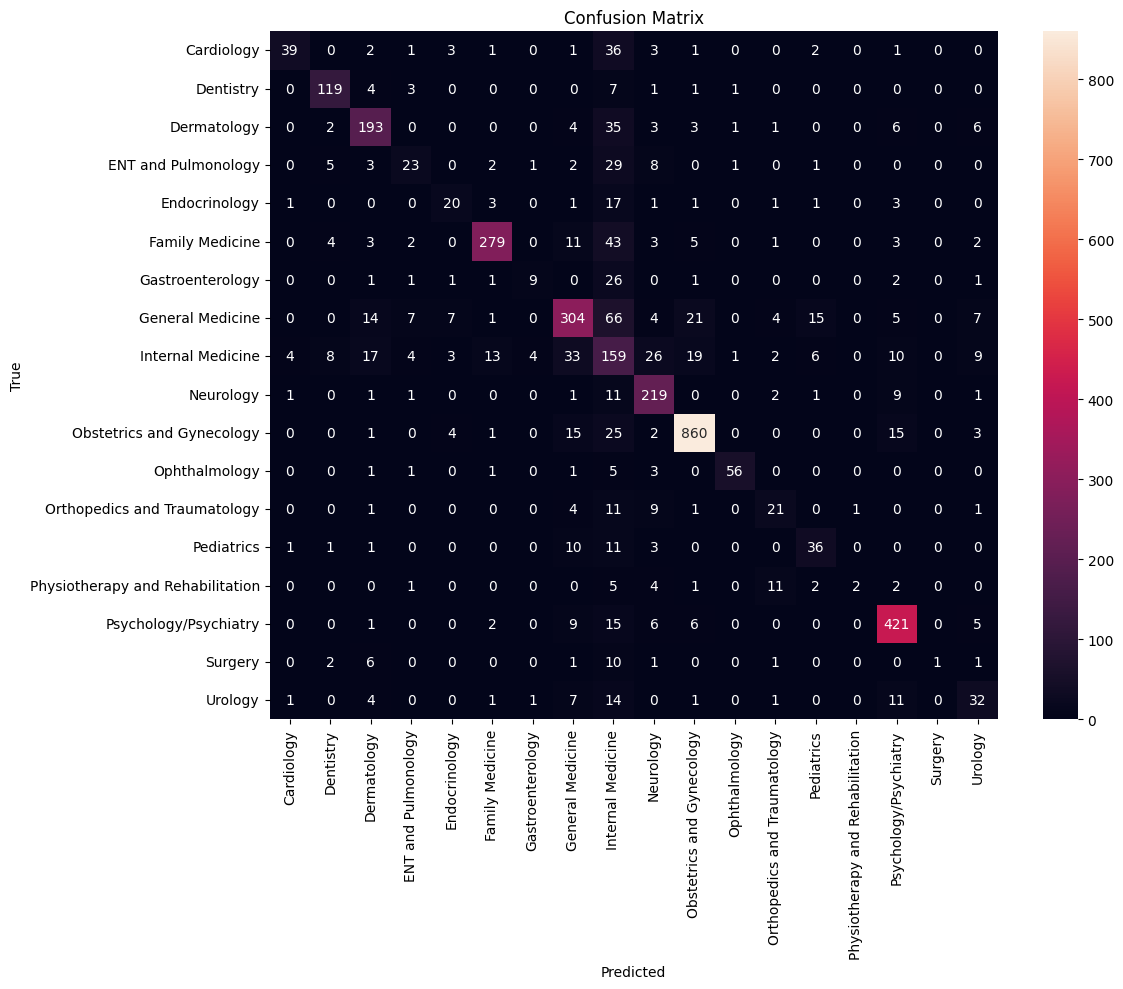

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [19]:
!ls

best_medical_classifier.keras  biobert_plain_embeddings.npy  drive  sample_data


In [20]:
!mkdir drive/MyDrive/noyau3

In [21]:
!cp biobert_plain_embeddings.npy drive/MyDrive/noyau3

In [22]:
!cp best_medical_classifier.keras drive/MyDrive/noyau3